# Tonnetz Diffusion

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

sns.set_context('talk')

import numpy as np
import statsmodels.api as sm
from scipy.stats import entropy

In [2]:
intervals = ['+P5', '-P5', '+m3', '-m3', '+M3', '-M3']

In [15]:
def plot_parameters(df, c_range, labels=None):
    
    fig, axes = plt.subplots(3,2,figsize=(16,10))
    axes = axes.flatten()

    for i, l, ax in zip(range(c_range[0], c_range[1]+1), labels, axes):
        sc = sns.regplot(
            x='year', 
            y=str(i), 
            data=df[df[str(i)]>0], 
            scatter_kws={'alpha':.3}, 
            line_kws={'color':'k'},
            marker='+',
            lowess=True,
            ax=ax
        )
        ax.set_ylabel(l)
        ax.set_xlabel('')
        ax.set_ylim(0,1)
    plt.tight_layout()
    return fig

In [4]:
def bootstrap_lowess(df, c_range, labels=None, B=100, scatter=True, colors=None):
    fig, axes = plt.subplots(3,2,figsize=(16,10))
    axes = axes.flatten()

    for i, l, ax in zip(range(c_range[0], c_range[1]+1), labels, axes):
        if scatter:
            sns.regplot(
            x='year', 
            y=str(i), 
            data=df[df[str(i)]>0], 
            scatter_kws={'alpha':.2}, 
            marker='+',
            fit_reg=False,
            ax=ax
        )
        
        for b in range(B):
            b_sample = df[[str(i), 'year']].sample(df.shape[0], replace=True)

            x = b_sample.year.values
            y = b_sample[str(i)].values
            lowess = sm.nonparametric.lowess(y, x, frac=0.3)

            ax.plot(lowess[:, 0], lowess[:, 1], alpha=.05, c=colors[i%6]['color'])
        ax.set_ylabel(l)

    plt.tight_layout()
    return fig

In [5]:
cols = ['JSDs'] + [str(i) for i in range(12)] + ['file'] + ['composer'] + ['year']
df = pd.read_csv('results.tsv', sep='\t', names=cols, header=0).sort_values(by='year')
df.head()

,JSDs,0,1,2,3,4,5,6,7,8,9,10,11,file,composer,year
1444,0.084306,0.546899,0.453101,1.145053e-16,0.000000e+00,3.797418e-17,0.000000e+00,0.825137,0.881071,4.187719e-01,0.559761,0.378611,1.122226e-01,..\ExtendedTonality\data\DataFrames\Lugentium-...,Vitry,1361.0
1442,0.082131,0.340914,0.632240,7.403419e-19,3.151637e-03,2.369442e-02,8.765961e-17,0.733203,0.893502,6.852771e-01,0.129920,0.067856,6.137037e-01,..\ExtendedTonality\data\DataFrames\Virtutibus...,Vitry,1361.0
1443,0.062455,0.669057,0.241962,3.861786e-02,9.336871e-13,1.611529e-13,5.036231e-02,0.981455,0.423207,5.527872e-13,0.666220,0.619354,7.413898e-13,..\ExtendedTonality\data\DataFrames\Gratissima...,Vitry,1361.0
1445,0.042667,0.561634,0.438366,4.000629e-17,8.746670e-17,1.521919e-16,7.014793e-17,0.893876,0.771316,3.005533e-01,0.617021,0.441614,8.065462e-02,..\ExtendedTonality\data\DataFrames\Rex-quem-m...,Vitry,1361.0
1400,0.045719,0.526563,0.473437,1.429368e-16,1.485737e-16,9.523765e-18,1.660025e-17,0.886907,0.791428,4.347314e-01,0.485341,0.239210,1.251366e-01,..\ExtendedTonality\data\DataFrames\Messe-de-N...,Machaut,1370.0


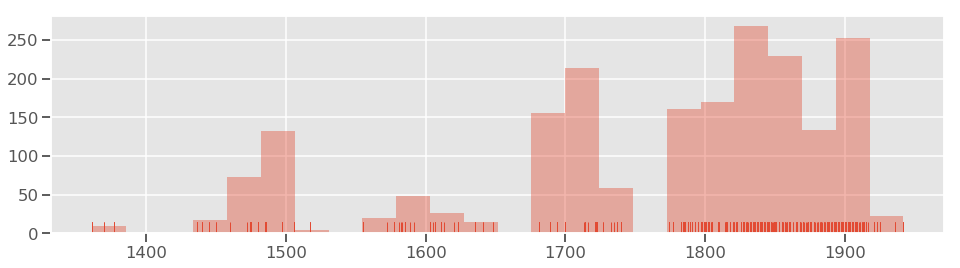

In [32]:
fig, ax = plt.subplots(figsize=(16,4))
sns.distplot(df.year.dropna(), rug=True, kde=False,norm_hist=False)
plt.xlabel('')
plt.savefig("img/corpus.png", dpi=300);

## Interval weights

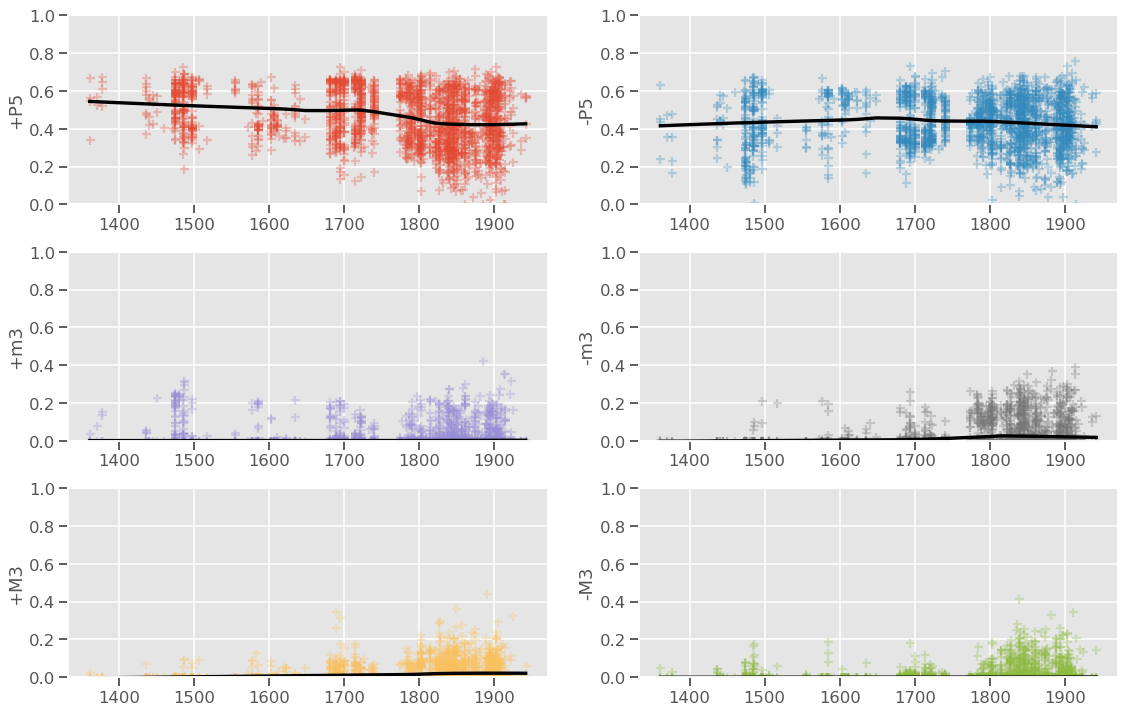

In [17]:
fig = plot_parameters(df, [0,5], labels=intervals)
plt.savefig('img/interval_weights.png', dpi=300)

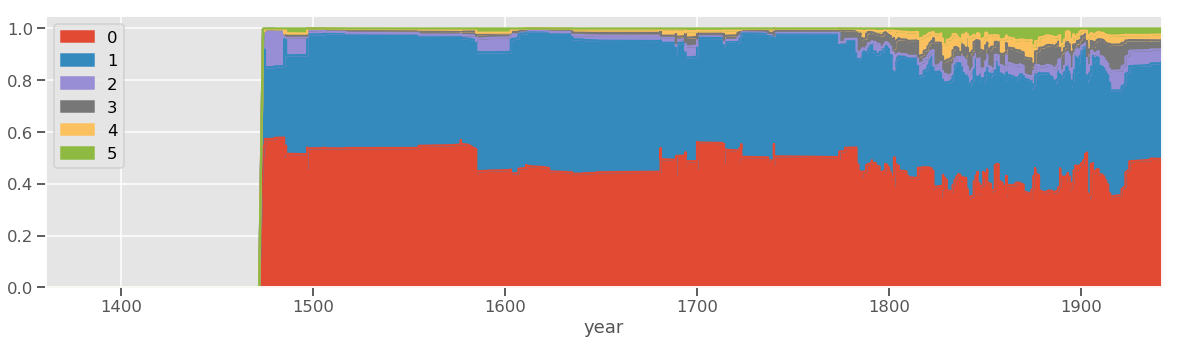

In [8]:
stacked = df.loc[:,[str(i) for i in range(6)]].rolling(window=30, win_type='cosine', center=False).mean()
stacked.index = df.year
stacked.plot(kind='area', figsize=(20,5))

plt.margins(0,0);

In [10]:
catcolors = list(plt.rcParams['axes.prop_cycle'])

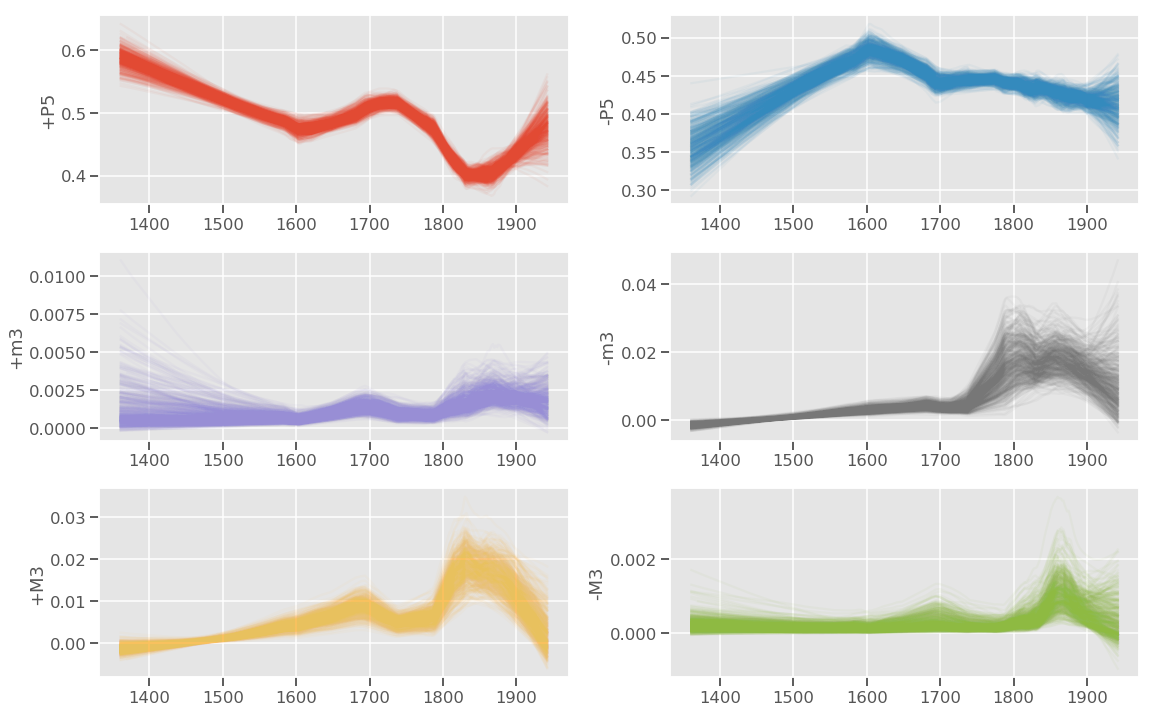

In [11]:
fig = bootstrap_lowess(df, [0,5], scatter=False, B=500, labels=intervals, colors=catcolors)
plt.savefig('img/bootstrapped_weights.png', dpi=300)

Observations:
* It seems that there are strong correlations between +m3 and -M3 (major triad), and between -m3 and +M3 (minor triad). Viewed absolutely, the major triad components are stronger (because minor is a mixed mode?)
* If also taking the fifths into account: how do dualistic theories play out?
* +P5 and -P5 are almost inverse patterns "W" and "M" (slightly shifted in time towards the end)

## Interval decays

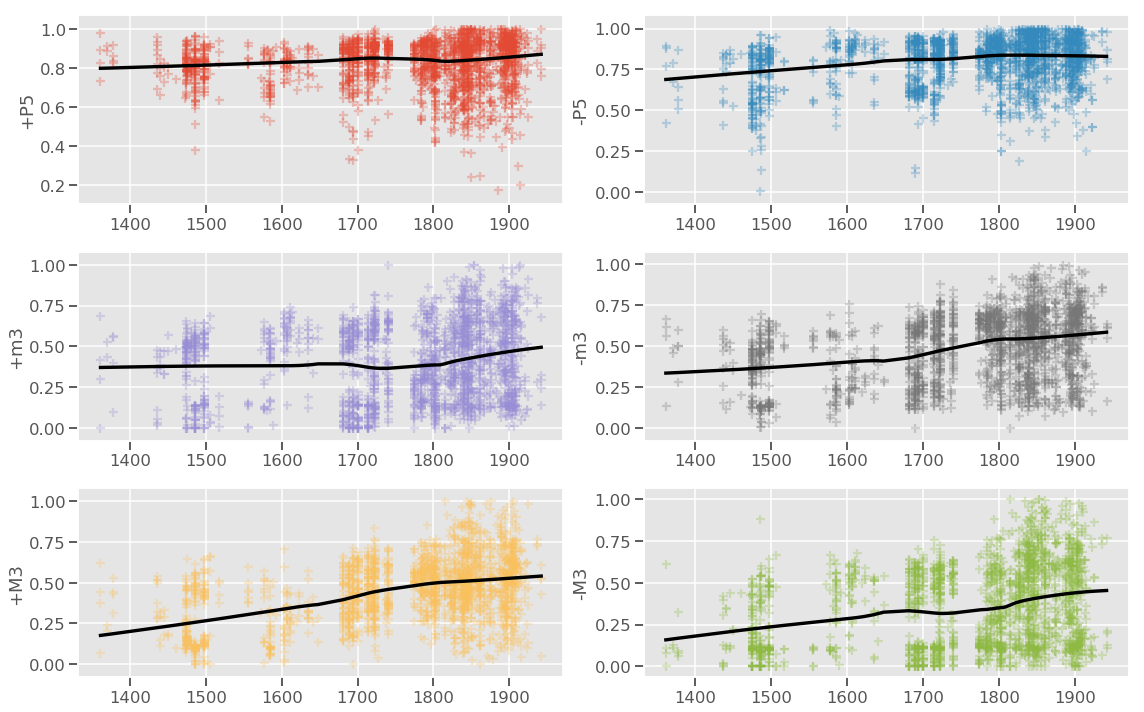

In [14]:
fig = plot_parameters(df, [6,12], labels=intervals)
plt.savefig('img/interval_params.png', dpi=300)

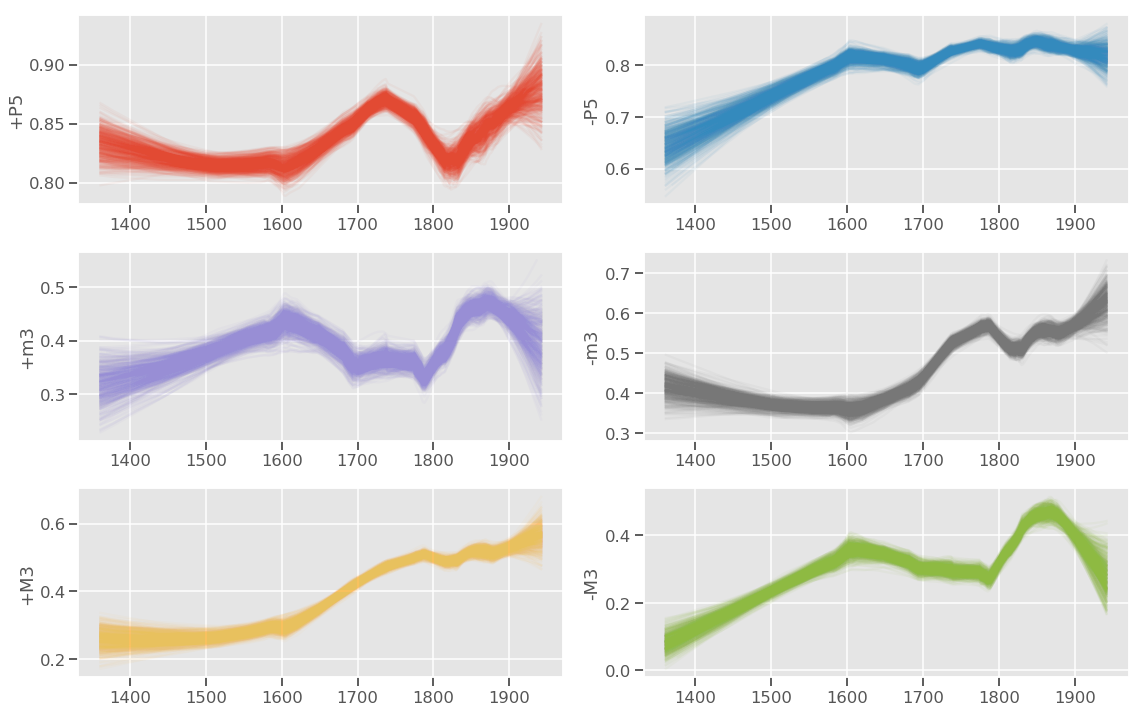

In [13]:
fig = bootstrap_lowess(df, [6,12], scatter=False, B=500, labels=intervals, colors=catcolors)
plt.savefig('img/bootstrapped_params.png', dpi=300)

## Divergences from true distributions per composer

In [62]:
df['sqrtJSDs'] = df['JSDs'].apply(np.sqrt)

In [63]:
df.sqrtJSDs.max()

0.40003025747721704

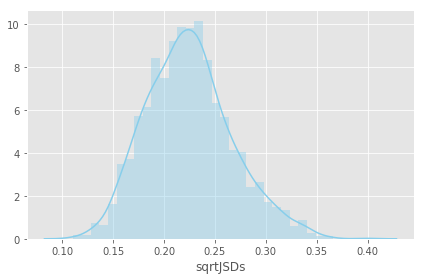

In [64]:
sns.distplot(df.sqrtJSDs, color='skyblue')
plt.tight_layout()
# plt.savefig('img/JSDs_dist.png', dpi=300);

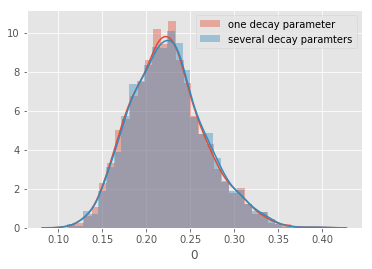

In [81]:
df1 = pd.read_csv('results_1.tsv', sep='\t')
df6 = pd.read_csv('results_6.tsv', sep='\t')
sns.distplot(df1.iloc[:,0].apply(np.sqrt), label='one decay parameter')
sns.distplot(df6.iloc[:,0].apply(np.sqrt), label='several decay paramters')
plt.legend();

It doesn't seem to make a difference whether there is one global decay parameter (per piece) or one for each interval.

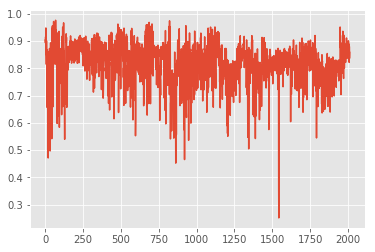

In [83]:
df1.iloc[:,7].plot();

The global parameter values are largely determined by the fifths (+/-P5). Since the third components (+/-m3, +/-M3) are relatively weak they don't fall into the weight.

What would be an objective measure to show that it is better to include decay parameters for all intervals separately? The $d_JS$ values are not sufficiently different. It _should_ be the case that if the global decay parameter is high (around .8) that the third components are much weaker because everything is already covered by the fifths.

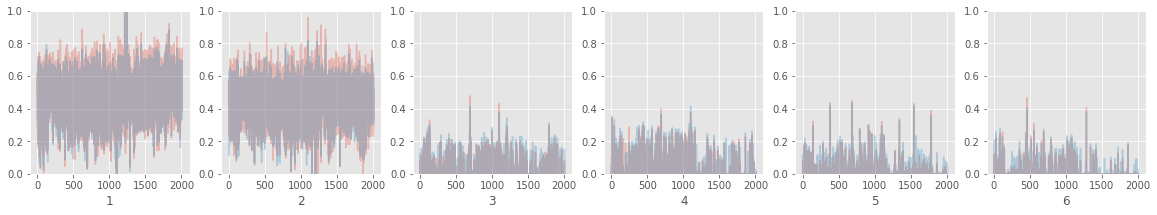

In [140]:
fig,axes = plt.subplots(1,6, figsize=(20,3))
for i in range(1,7):
    df1.iloc[:,i][df1.iloc[:,i]>0].plot(ax=axes[i-1], alpha=.3)
    df6.iloc[:,i][df6.iloc[:,i]>0].plot(ax=axes[i-1], alpha=.3)
    axes[i-1].set_xlabel(i)
    axes[i-1].set_ylim(0,1)
plt.show()

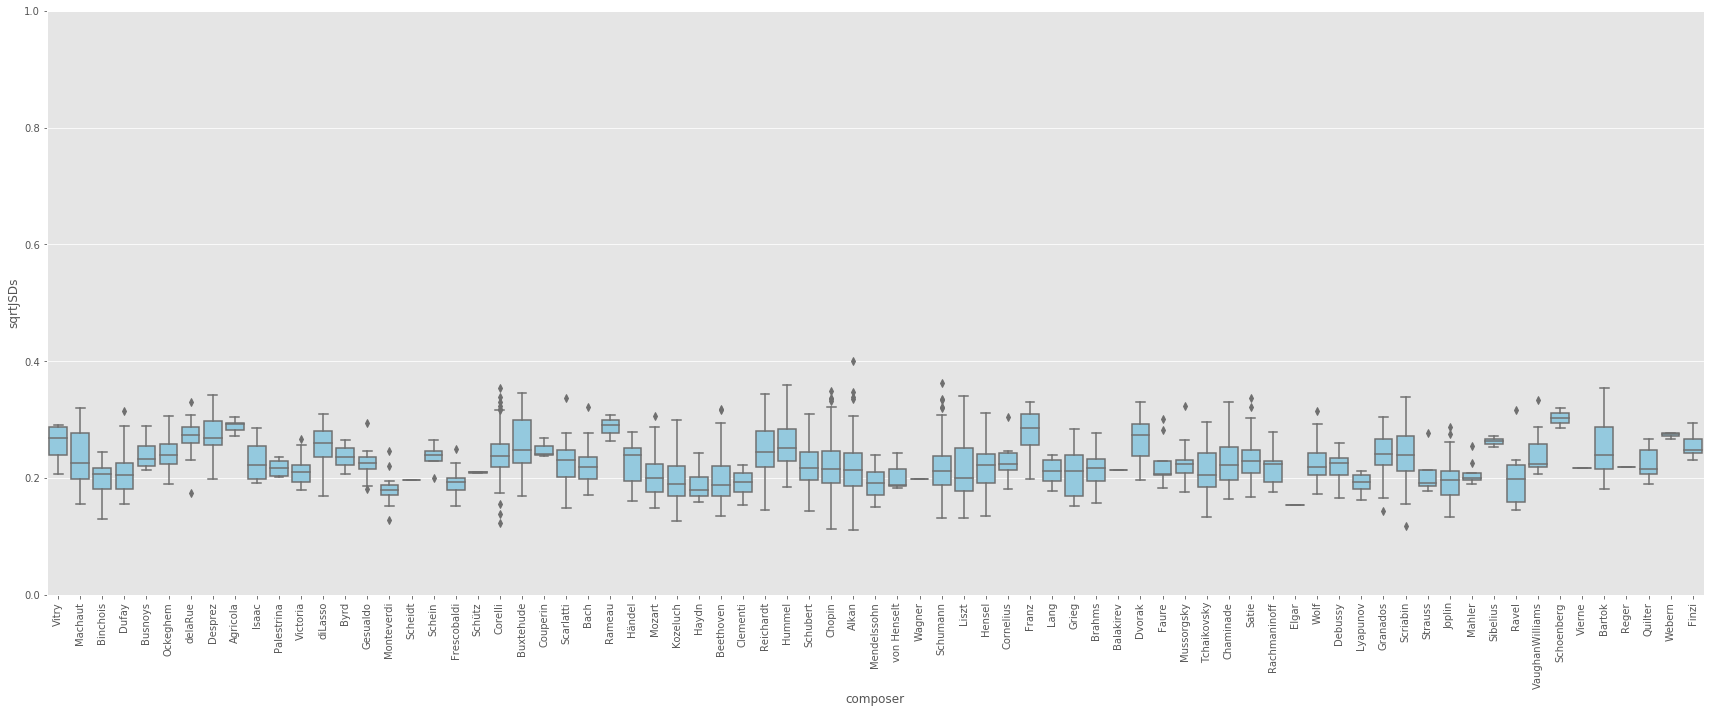

In [67]:
fig, ax = plt.subplots(figsize=(24,10))

sns.boxplot(
    x="composer", 
    y="sqrtJSDs",
    color='skyblue',
    data=df, ax=ax)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.tight_layout()
plt.ylim(0,1)
# plt.savefig('img/JSDs_composers.png', dpi=300)
plt.show()

In [15]:
best = df.loc[df.sqrtJSDs.idxmin()]
best

JSDs                                                0.0122572
0                                                    0.291518
1                                                    0.450456
2                                                   0.0838312
3                                                    0.126512
4                                                   0.0274615
5                                                   0.0202213
6                                                     0.80718
7                                                    0.937718
8                                                    0.655795
9                                                    0.649903
10                                                    0.52406
11                                                   0.599993
file        ..\ExtendedTonality\data\DataFrames\Scherzo_Fo...
composer                                                Alkan
year                                                     1847
sqrtJSDs

In [16]:
worst = df.loc[df.sqrtJSDs.idxmax()]
worst

JSDs                                                 0.160024
0                                                    0.391691
1                                                    0.168153
2                                                    0.274584
3                                                 3.46159e-19
4                                                   0.0818809
5                                                    0.083691
6                                                    0.756891
7                                                    0.496177
8                                                    0.836205
9                                                    0.188351
10                                                  0.0740605
11                                                   0.736131
file        ..\ExtendedTonality\data\DataFrames\Un_Morceau...
composer                                                Alkan
year                                                     1840
sqrtJSDs

### Symmetry (dualistic perspective)
#### Parameter weights

In [9]:
ints = df[[str(i) for i in range(6)]].copy()
ints = ints.melt()
ints.variable = ints.variable.astype(int)
ints['direction'] = np.where(ints['variable'].apply(pd.to_numeric) % 2 == 0, 'acending', 'descending')
ints['interval'] = ['P5' if s in (0,1) else 'm3' if s in (2,3) else 'M3' if s in (4,5) else '' for s in ints.variable.values]
ints.head()

,variable,value,direction,interval
0,0,0.546899,acending,P5
1,0,0.340914,acending,P5
2,0,0.669057,acending,P5
3,0,0.561634,acending,P5
4,0,0.526563,acending,P5


How does the symmetry change over time? Could the 19th century theorists have been "mislead" by contemporary music?

#### Parameter decays

In [10]:
dec = df[[str(i) for i in range(6,12)]].copy()
dec = dec.melt()
dec.variable = dec.variable.astype(int)
dec['direction'] = np.where(dec['variable'].apply(pd.to_numeric) % 2 == 0, 'acending', 'descending')
dec['interval'] = ['P5' if s in (6,7) else 'm3' if s in (8,9) else 'M3' if s in (10,11) else '' for s in dec.variable.values]
dec.head()

,variable,value,direction,interval
0,6,0.825137,acending,P5
1,6,0.733203,acending,P5
2,6,0.981455,acending,P5
3,6,0.893876,acending,P5
4,6,0.886907,acending,P5


#### Plot

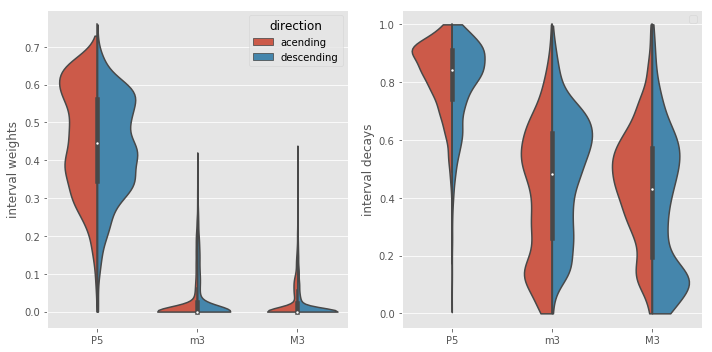

In [19]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

sns.violinplot(
    data=ints, 
    x='interval', 
    y='value', 
    hue='direction', 
    split=True,
    cut=0,
    ax=axes[0],
)
axes[0].set_ylabel('interval weights')
axes[0].set_xlabel('')

sns.violinplot(
    data=dec, 
    x='interval', 
    y='value', 
    hue='direction', 
    split=True,
    cut=0,
    ax=axes[1]
)
axes[1].set_ylabel('interval decays')
axes[1].set_xlabel('')
axes[1].legend('')

plt.tight_layout()
plt.savefig('img/parameter_dists.png', dpi=300);

### Parameter Clustering

In [59]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [34]:
scaler = StandardScaler()
tsne = TSNE(n_components=2, perplexity=30)

In [198]:
X_ = tsne.fit_transform(df.loc[:,[str(i) for i in range(6,12)]])

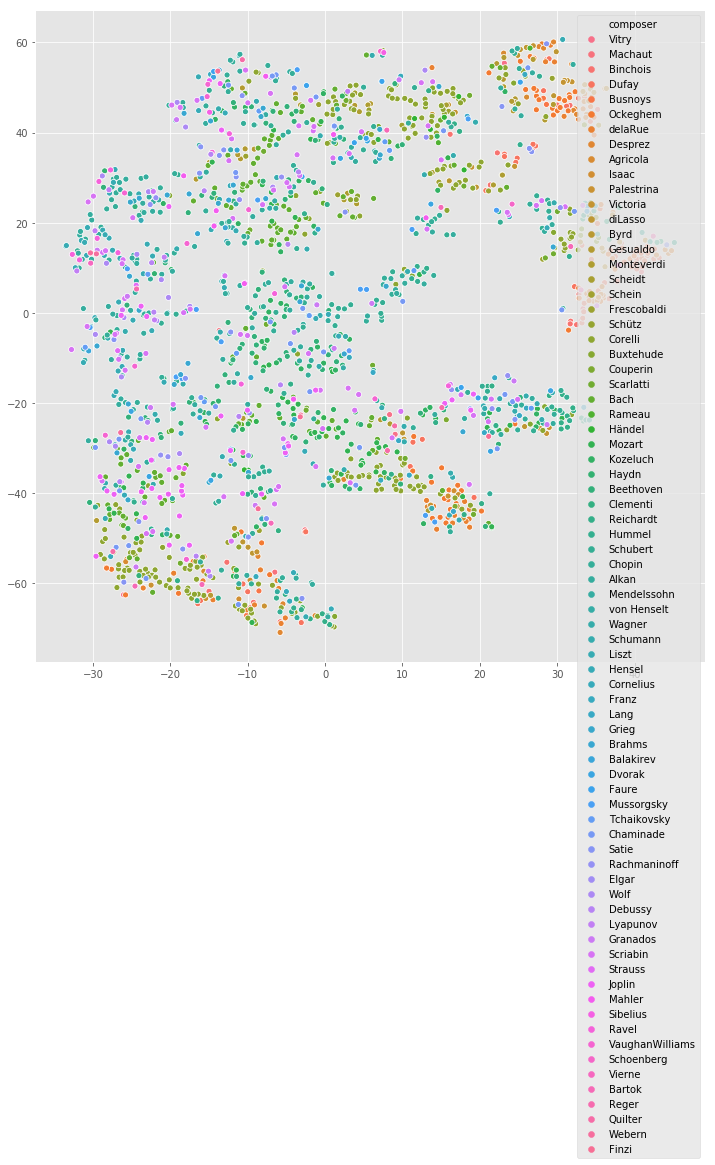

In [199]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x=X_[:,0], y=X_[:,1], hue=df.composer, ax=ax);

In [54]:
X_ = df.loc[:,[str(i) for i in range(6,12)]]

pca = PCA(n_components=2)
Y_ = pca.fit_transform(X_)

In [55]:
pca.explained_variance_ratio_[0]

0.5650014569051509

In [56]:
df['PC1'] = Y_[:,0]
df['PC2'] = Y_[:,1]

In [57]:
pca_composers = df.groupby('composer')[['PC1', 'PC2']].median()

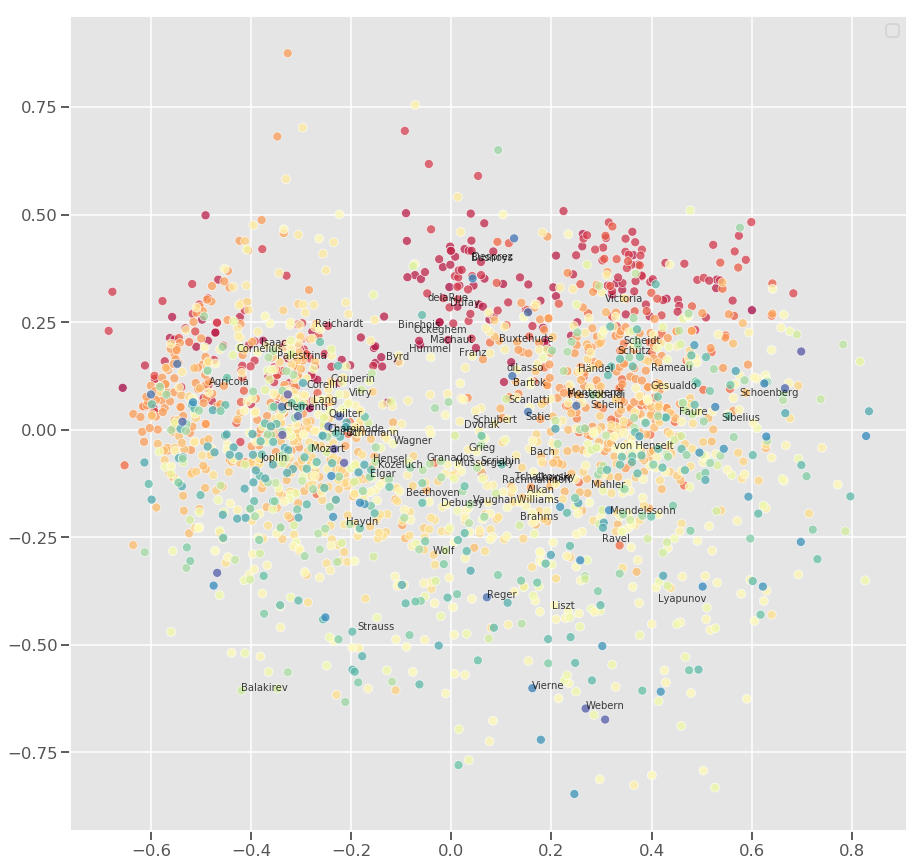

In [58]:
fig, ax = plt.subplots(figsize=(15,15))

sns.scatterplot(Y_[:,0], Y_[:,1], alpha=.75, marker='o', hue=df.composer, palette='Spectral')
# ax.scatter()
for c, (x,y) in pca_composers.iterrows():
    ax.text(x,y,c, alpha=.75, size=10)
    
# ax.set_xlim(-.3,.4)
# ax.set_ylim(-.1,.4)

plt.legend('');

In [27]:
from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl

In [637]:
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

def plot_results(X, Y_, means, covariances, ax=None, color=(0,0,0)):
    for (mean, covar) in zip(means, covariances):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.3)
        ax.add_artist(ell)

In [638]:
g = df.groupby('composer')[['PC1', 'PC2']]

In [677]:
cmap = plt.get_cmap('Spectral')
colors = [cmap(i/df.composer.unique().shape[0]) for i, c in enumerate(df.composer.unique())]

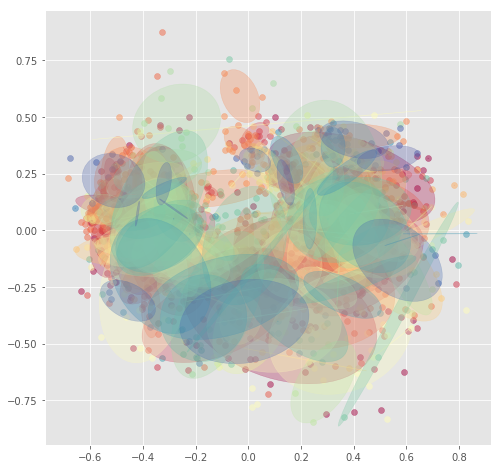

In [685]:
fig, ax = plt.subplots(figsize=(8,8))

for i in range(df.composer.unique().shape[0]):
    color = colors[i]
    coords = g.aggregate(list).values[i]
    X = np.array(list(zip(coords[0], coords[1])))  
    
    n = 4
    
    if X.shape[0] > n-1:    
        ax.scatter(X[:,0], X[:,1], color=color, alpha=.5)

        gmm = GaussianMixture(n_components=n)
        X_ = gmm.fit(X)

        plot_results(X,X_, X_.means_, X_.covariances_, ax=ax, color=color)
        
plt.show()